<a href="https://colab.research.google.com/github/DKorchagina/industrial-development-git-control-task/blob/main/imageRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.models import save_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, AveragePooling2D
import tensorflow_datasets as tfds
import tensorflow as tf
import logging
import numpy as np
import time


import tensorflow_hub as hub



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Creating a model and training in on a "cats_vs_dogs" tensorflow_datasets

In [ ]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(cat_train, cat_valid, cat_test), info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train['
                                                                                                             '90%:]'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4RXXW3/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
def pre_process_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches = cat_train.cache().shuffle(num_examples//4).map(pre_process_image).batch(BATCH_SIZE).prefetch(1)
validation_batches =cat_valid.map(pre_process_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape = (IMAGE_RES, IMAGE_RES, 3))

TF version: 2.8.2
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([feature_extractor, layers.Dense(2)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
EPOCHS = 3
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 512s 863ms/step - loss: 0.0508 - accuracy: 0.9836 - val_loss: 0.0375 - val_accuracy: 0.9880
Epoch 2/3
582/582 [==============================] - 529s 908ms/step - loss: 0.0295 - accuracy: 0.9896 - val_loss: 0.0397 - val_accuracy: 0.9875
Epoch 3/3
582/582 [==============================] - 527s 905ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.0389 - val_accuracy: 0.9884


In [ ]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [ ]:
export_path_keras = "/gdrive/MyDrive/Colab Notebooks/dogs_cats.h5"
print(export_path_keras)
model.save(export_path_keras)

/gdrive/MyDrive/Colab Notebooks/dogs_cats.h5


In [ ]:
!ls "/gdrive/MyDrive/Colab Notebooks"

ls: cannot access '/gdrive/MyDrive/Colab Notebooks': No such file or directory


Find category

In [ ]:
def dog_cat_predict(model, image_file):
  label_names = ['cat', 'dog']
  img = keras.preprocessing.image.load_img(image_file, target_size=(224, 224))
  img_arr = np.expand_dims(img, axis=0) / 255.0
  result = model.predict(img_arr)
  result = tf.squeeze(result).numpy()
  result_ids = np.argmax(result, axis = -1)
  return label_names[result_ids]

In [ ]:
model = tf.keras.models.load_model("/gdrive/MyDrive/Colab Notebooks/dogs_cats.h5", custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()
print(dog_cat_predict(model, "/gdrive/MyDrive/Colab Notebooks/data/find_category/test.jpg"))
print(dog_cat_predict(model, "/gdrive/MyDrive/Colab Notebooks/data/find_category/test_cat.jpg"))
print(dog_cat_predict(model, "/gdrive/MyDrive/Colab Notebooks/data/find_category/test_dog.jpg"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
dog
cat
dog


Image comparison

In [ ]:
from PIL import Image
def class_histogram(image1, image2):
  size=(224, 224)
  image1 = Image.open(image1)
  image1 = image1.resize(size).convert("RGB")
  image2 = Image.open(image2)
  image2 = image2.resize(size).convert("RGB")
  hist1 = image1.histogram()
  hist2 = image2.histogram()
  assert len(hist1)==len(hist2), "error"
  data = []
  for index in range(0, len(hist1)):
    if hist1[index]!= hist2[index]:
      data.append(1-abs(hist1[index]-hist2[index])/max(hist1[index], hist2[index]))
    else:
      data.append(1)
  return sum(data)/len(hist1)

In [ ]:
print(class_histogram("/gdrive/MyDrive/Colab Notebooks/data/find_category/test_dog.jpg", "/gdrive/MyDrive/Colab Notebooks/data/zoozabota/fensi.jpg"))
print(class_histogram("/gdrive/MyDrive/Colab Notebooks/data/find_category/test_dog.jpg", "/gdrive/MyDrive/Colab Notebooks/data/zoozabota/pry.jpg"))
print(class_histogram("/gdrive/MyDrive/Colab Notebooks/data/find_category/test_dog.jpg", "/gdrive/MyDrive/Colab Notebooks/data/zoozabota/salli.jpg"))
print(class_histogram("/gdrive/MyDrive/Colab Notebooks/data/zoozabota/fensi.jpg", "/gdrive/MyDrive/Colab Notebooks/data/zoozabota/fensi.jpg"))

0.25705867849418995
0.22548234313163865
0.1723226020048498
1.0


In [ ]:
max_comp = 0
max_filename = "/gdrive/MyDrive/Colab Notebooks/data/find_category/test_dog.jpg"
import os
for filename in os.listdir('/gdrive/MyDrive/Colab Notebooks/data/zoozabota'):
  filename = "%s/%s" % ('/gdrive/MyDrive/Colab Notebooks/data/zoozabota', filename)
  comp = class_histogram("/gdrive/MyDrive/Colab Notebooks/data/find_category/test_dog.jpg", filename)
  if comp > max_comp:
    max_comp = comp
    max_filename = filename
print(max_comp, max_filename)

0.25705867849418995 /gdrive/MyDrive/Colab Notebooks/data/zoozabota/fensi.jpg


0.5329125724784106 /gdrive/MyDrive/Colab Notebooks/data/zoozabota/lajma.jpg


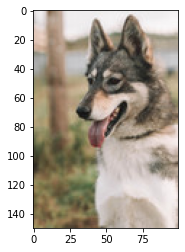

In [ ]:
import os
import matplotlib.pylab as plt
file_find = "/gdrive/MyDrive/Colab Notebooks/data/find_category/test.jpg"
model = tf.keras.models.load_model("/gdrive/MyDrive/Colab Notebooks/dogs_cats.h5", custom_objects={'KerasLayer':hub.KerasLayer})
result = dog_cat_predict(model, file_find)
if result=='cat':
  print("На фото не изображена собака")
else:
  max_comp = 0
  max_filename = file_find
  for filename in os.listdir('/gdrive/MyDrive/Colab Notebooks/data/zoozabota'):
    if filename != '.ipynb_checkpoints':
      filename = "%s/%s" % ('/gdrive/MyDrive/Colab Notebooks/data/zoozabota', filename)
      comp = class_histogram(file_find, filename)
      if comp > max_comp:
        max_comp = comp
        max_filename = filename
  print(max_comp, max_filename)

img = plt.imread(max_filename)
plt.imshow(img)
plt.show()

Search for a similar dog photo

In [ ]:
def find_photo(file_find):
  model = tf.keras.models.load_model("/gdrive/MyDrive/Colab Notebooks/dogs_cats.h5", custom_objects={'KerasLayer':hub.KerasLayer})
  result = dog_cat_predict(model, file_find)
  if result=='cat':
    return 'error', 0
  else:
    max_comp = 0
    max_filename = file_find
  for filename in os.listdir('/gdrive/MyDrive/Colab Notebooks/data/zoozabota'):
    if filename != '.ipynb_checkpoints':
      filename = "%s/%s" % ('/gdrive/MyDrive/Colab Notebooks/data/zoozabota', filename)
      comp = class_histogram(file_find, filename)
      if comp > max_comp:
        max_comp = comp
        max_filename = filename
  return max_filename, max_comp


Implementation of the search for a dog similar to a photo using a telegram bot

In [ ]:
pip install pytelegrambotapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 14.1 MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.5.1-py3-none-any.whl size=138116 sha256=4c0a285ef8195a0f879d8f907c133ce784733644c1242d859bb616cfcdb40b94
  Stored in directory: /root/.cache/pip/wheels/9a/90/69/89e4e68c819633d933753827fd4f3a22987e162b7404b092b5
Successfully built pytelegrambotapi


In [ ]:
import telebot
from telebot import types
bot = telebot.TeleBot('5476561168:AAHxpw3ohBOALXt7oACqe1JjYNesFvwN82w')
f = open("/gdrive/MyDrive/Colab Notebooks/data/info.txt")
shelters = f.read()
f.close()
@bot.message_handler(commands=["start"])
def start(m, res=False):
  markup=types.ReplyKeyboardMarkup(resize_keyboard=True)
  item1 = types.KeyboardButton("Загрузить фотографию")
  item2 = types.KeyboardButton("Список приютов")
  markup.add(item1)
  markup.add(item2)
  bot.send_message(m.chat.id, "Здравствуйте! Я бот, который по фотографии собаки покажет, в каком приюте Ярославской области есть похожая собака. Нажмите \nЗагрузить фотографию для поиска по фотографии или \nСписок приютов для выдачи информации о приютах для собак в Ярославской области", reply_markup=markup)

@bot.message_handler(content_types=['text'])
def handle_text(message):
  if message.text.strip()=="Загрузить фотографию":
    answer = "Загрузите фотографию"
    bot.send_message(message.chat.id, answer)
  elif message.text.strip()=='Список приютов':
    answer =shelters
    bot.send_message(message.chat.id, answer)
  else:
    answer = "Непонятная команда. Попробуйте ввести команду заново."
    bot.send_message(message.chat.id, answer)
@bot.message_handler(content_types=['photo'])
def handle_photo(message):
  file_info = bot.get_file(message.photo[len(message.photo)-1].file_id)
  downloaded_file = bot.download_file(file_info.file_path)
  src = "/gdrive/MyDrive/Colab Notebooks/data/find/jpg"
  with open(src, 'wb') as new_file:
    new_file.write(downloaded_file)
  result, max_comp = find_photo(src)
  if result == 'error':
    bot.send_message(message.chat.id, "Ошибка. Я не могу разглядеть на фотографии собаку.")
  else:
    if max_comp==0:
      bot.send_message(message.chat.id, "Я не могу найти похожую собаку. Пожалуйста, попробуйте запустить поиск позже.")
    else:
      with open(result, 'rb') as photo:
        bot.send_message(message.chat.id, "Поиск похожей собаки в приюте Ковчег. Найдена максимально похожая собака")
        bot.send_photo(message.chat.id, photo)
bot.polling(none_stop=True, interval=0)